# Generative Adversarial Network


##Chuẩn bị dữ liệu

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

In [ ]:
# Dữ liệu FashionMNIST
# train_dataGAN = datasets.FashionMNIST(root='data', train=True,download=True, transform=transform)
# Dữ liệu MNIST
train_dataGAN = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# prepare data loader
train_loaderGAN = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [3]:
# Dữ liệu DCGAN
img_resize = 32   # resize to 32x32 imgs
transform = transforms.Compose([transforms.Resize(img_resize), transforms.ToTensor()])
train_dataDCGAN = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# train_dataDCGAN = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
# prepare data loader
train_loaderDCGAN = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Trực quan dữ liệu

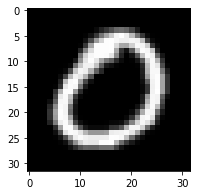

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader) #iter -- trả về đối tượng iterator có thể sử dụng cho for...
images, labels = dataiter.next() #next() -- lấy lần lượt một phần tử trong danh sách
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[7])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Xây dựng mô hình

GAN gồm hai mạng đối nghịch, mô hình phân biệt và mô hình sinh

## Basic Discriminator
Mạng Discriminator phiên bản cơ bản là một mô hình phân biệt tuyến tính (linear classisfier) 


*   Hàm kích hoạt sử dụng Leaky ReLU
*   Output: 0-1 để đưa ra ảnh giả hay ảnh thật (BCEWithLogitsLoss đã bao gồm hàm sigmoid nên không cần thêm hàm kích hoạt ở layer cuối)
* Hàm Loss: BCEWithLogitsLoss

In [36]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        # define all layers
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x) #Sử dụng dropout để làm mịn kết quả
        # final layer
        out = self.fc4(x)
        return out

##Basic Generator

Mạng Generator được cài đặt tương tự như discriminator ngoại trừ áp dụng hàm tanh cho ouput layer - cho kết quả -1 và 1 thay vì 0 - 1.
> Chuẩn hóa giá trị pixel ảnh thực đưa vào về khoảng -1 và 1 khi huấn luyện mạng Discriminator

In [37]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # all hidden layers
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x) #Sử dụng dropout để làm mịn kết quả
        # final layer
        out = torch.tanh(self.fc4(x))
        return out

## DCGAN Discriminator
*   Sử dụng bộ lọc kích thước 32 ở lớp đầu tiên và gấp đôi kích thước theo độ sâu layer
*   Sử dụng BatchNorm2d để chuẩn hóa tham số
* Hàm Loss: BCEWithLogitsLoss
> kernel_size đề xuất: 2, 4

In [38]:


# Hàm conv giúp tạo một lớp convolution sử dụng batch_norm
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [39]:
class DCDiscriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(DCDiscriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

##DCGAN Generator

* size của $z$ = size ảnh

Sử dụng transpose convolutional layers để tạo ảnh mới
* Lớp đầu tiên: fully connected layer 
* Sử dụng batch normalization và leaky ReLU
* Các lớp sau: transpose convolutional layers (*gấp đôi kích thước và chiều cao so với lớp trước*)
* Lớp cuối: chỉ sử dụng hàm kích hoạt tanh thay vì batch normalization và ReLU như các lớp khác

In [40]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [41]:


class DCGenerator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(DCGenerator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 1, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

## Model hyperparameters

In [42]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 256

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of generator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 256

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [43]:
# Mô hình GAN cơ bản
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [44]:
conv_dim = 32
z_size = 100

# define discriminator and generator
D = DCDiscriminator(conv_dim)
G = DCGenerator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

DCDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

DCGenerator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

In [45]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


---
## Discriminator and Generator Losses

### Discriminator Losses

> * `d_loss = d_real_loss + d_fake_loss` - Discriminator loss = tổng hàm mất mát của ảnh thật và ảnh giả
* Mục tiêu là ảnh thật sẽ đưa ra giá trị = 1, ảnh giả sẽ đưa ra giá trị = 0
* BCEWithLogitsLoss
>
Làm mịn kết quả của Discriminator bằng cách giảm giá trị output của ảnh thật là 0.9. 
Chú ý ảnh thật được lấy từ kết quả `fake_images = G(z)`. 

### Generator Loss
Tương tự như Discriminator loss nhưng với flipped labels do mục tiêu là  `D(fake_images) = 1`. Labels được **flipped** thể hiện generator muốn lừa discriminator rằng ảnh giả là thật, vì vậy Generator Loss được tính bằng `g_loss = real_loss(D_fake) `.

In [46]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9gh=
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()    
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [47]:

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training
Quá trình huấn luyện bao gồm sự thay phiên huấn luyện giữa mô hình phân biệt và mô hình sinh.

### Discriminator training
1. Tính Discriminator loss trên ảnh thật.     
2. Sinh ảnh giả
3. Tính Discriminator loss trên ảnh giả.     
4. Cộng real loss và fake loss
5. Thực hiện bước backpropagation + optimization để cập nhật discriminator weights

### Generator training
1. Sinh ảnh giả - fake images
2. Tính discriminator loss trên fake images, sử **flipped** labels - `g_loss = real_loss(D_fake)`
3. Thực hiện bước backpropagation + optimization để cập nhật generator weights

In [48]:
import pickle as pkl

# training hyperparams
num_epochs = 15

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=32
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = real_images*2 - 1          
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        # print(z.shape)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   15] | d_loss: 1.6181 | g_loss: 0.8078
Epoch [    1/   15] | d_loss: 0.3645 | g_loss: 3.8498
Epoch [    1/   15] | d_loss: 0.1359 | g_loss: 3.8369
Epoch [    1/   15] | d_loss: 0.1866 | g_loss: 2.9707
Epoch [    2/   15] | d_loss: 0.1776 | g_loss: 5.3023
Epoch [    2/   15] | d_loss: 2.4946 | g_loss: 8.0792
Epoch [    2/   15] | d_loss: 0.5016 | g_loss: 3.5512
Epoch [    2/   15] | d_loss: 0.2077 | g_loss: 2.3692
Epoch [    3/   15] | d_loss: 0.1839 | g_loss: 2.3044
Epoch [    3/   15] | d_loss: 0.2534 | g_loss: 4.3747
Epoch [    3/   15] | d_loss: 0.2391 | g_loss: 2.5219
Epoch [    3/   15] | d_loss: 0.1580 | g_loss: 2.8593
Epoch [    4/   15] | d_loss: 0.4047 | g_loss: 2.6501
Epoch [    4/   15] | d_loss: 0.1604 | g_loss: 5.9421
Epoch [    4/   15] | d_loss: 3.8694 | g_loss: 5.9836
Epoch [    4/   15] | d_loss: 0.1088 | g_loss: 3.5784
Epoch [    5/   15] | d_loss: 0.0508 | g_loss: 3.4725
Epoch [    5/   15] | d_loss: 0.4235 | g_loss: 1.5295
Epoch [    5/   15] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

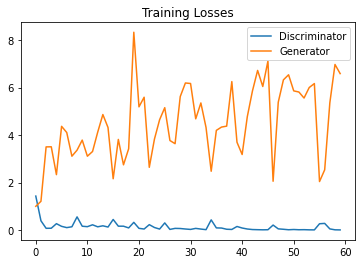

In [28]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, image_size):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((image_size,image_size)), cmap='Greys_r')

In [30]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
# samples = samples.cpu()
samples_cpu = []
for sample in samples:
  sample = sample.cpu()
  samples_cpu.append(sample)
# samples_cpu

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

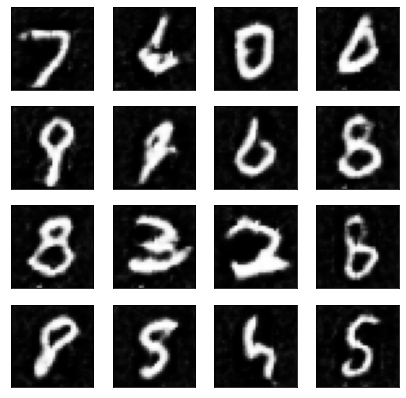

In [32]:
# -1 indicates final epoch's samples (the last in the list)
# DCGAN
view_samples(-1, samples_cpu, 32)
# GAN thường
# view_samples(-1, samples_cpu, 28)

Below I'm showing the generated images as the network was training, every 10 epochs.

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples_cpu[::int(len(samples_cpu)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        # IMAGE SIZE = 32 VỚI DCGAN
        # ax.imshow(img.reshape((32,32)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


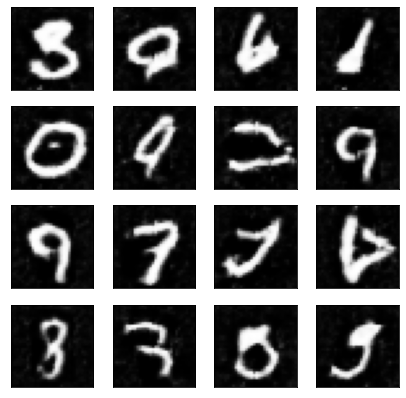

In [35]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
if train_on_gpu:
  rand_z = rand_z.cuda()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
randimages_cpu = []
for sample in rand_images:
  sample = sample.cpu()
  randimages_cpu.append(sample)
# samples_cpu
# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [randimages_cpu])